## Power Analysis and Selecting the Right Test Statistic

I put together this notebook partially to reinforce the ThinkPython material on hypothesis testing, and partially to answer a question posed (I think) by Jacob Kingery.

> If p-values can be thought of as the probability of an effect happening by chance, isn't it weird that it can change based on the test statistic (such as total deviation vs. chi-squared)?  Was one of these just the wrong thing to do?  A 4% chance is a lot different than a 13% chance.

There are a few concerns to worry about when selecting a test statistic for performing a signifiance test.  Mainly we are interested in the following types of errors:
1.  Type 1 error:  this occurs when the null hypothesis is rejected when in fact it is true.  Another way to think of this is as a false positive.  That is, we have declared that it is unlikely we would have seen the result we did if the null hypothesis was true (e.g. if the mean really is 0), however, the null hypothesis was in fact true.
2.  Type 2 error: this occurs when we fail to reject the null hypothesis.  This can also be thought of as a false negative.  That is, even though the data had some sort of pattern, we were not able to reject the null hypothesis.

The probability of a type 1 error is controlled by the threshold that we use for the p-value for rejecting the null-hypothesis.  If we choose the traditional value of $p \leq .05$, then we have a 5% chance of a type 1 error.  Type 2 errors can come from several factors.  First, we might not have enough data to reject the null hypothesis.  Second, we might be using a suboptimal test statistic.

In this notebook we are going to look at the effect that the choice of test statistic could have on the probability of committing a type 2 error.  The example we will be using comes from the ThinkPython reading.  Specifically, we will be trying to determine if the experiments we get from rolling a 6-sided die 60 times provide enough evidence to reject the null hypothesis that the die is fair.  

> Suppose you run a casino and you suspect that a customer is using a crooked die; that is, one that has been modified to make one of the faces more likely than the others. You apprehend the alleged cheater and confiscate the die, but now you have to prove that it is crooked. You roll the die 60 times and get the following results:

> |Value|1|2|3|4|5|6|
> |---|---|---|---|---|---|---|
> |Frequency|8|9|19|5|8|11|

Is this die fair?  To investigate the question, we define two test statistics: sum of absolute deviations and chi squared.

In [3]:
def abs_deviation_stat(observed, expected):
    """ Computes the sum of absolute deviations from
        the expected to the observed.  observed and
        expected are both dictionaries that map from
        events to counts. """
    return sum(abs(observed[k] - expected[k]) for k in expected)

def chi2_stat(observed, expected):
    """ Computes the sum of chi2 statistic between
        the expected and the observed.  observed and
        expected are both dictionaries that map from
        events to counts. """
    return sum((observed[k] - expected[k])**2/expected[k] for k in expected)

# this is the data from ThinkStats2 Chapter 9
expected = {1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10}
observed = {1: 8, 2: 9, 3: 19, 4: 5, 5: 8, 6: 11}

observed_abs_deviation_stat = abs_deviation_stat(expected, observed)
print "observed absolute deviation stat", observed_abs_deviation_stat

observed_chi2_stat = chi2_stat(expected, observed)
print "observed chi2 stat", observed_chi2_stat

observed absolute deviation stat 20
observed chi2 stat 9


In [18]:
import sys
sys.path.append('../../ThinkStats2')
import thinkstats2
import numpy as np
from numpy.random import choice

def simulate_die(probs, n):
    """ Compute the histogram of outcomes from rolling die with
        faces given by the keys of the dictionary `probs` and
        probabilities given by the value sof the dictionary `probs`
    """
    rolls = choice(probs.keys(), n, p=probs.values())
    return thinkstats2.Hist(rolls)

def get_p_vals(obs_abs_stat, obs_chi2_stat, num_rolls, n_trials):
    """ Compute the p_values for both the absolute deviation statistic
        and the chi2 statistic using `n_trials` simulations.
        The function returns the two p-values as a tuple where
        the first element the p-value as computed using the absolute
        deviation statistic and the second is the p-value using the
        chi2 statistic. """
    trials_abs_stat = []
    trials_chi2_stat = []
    null_probs = {1: 1/6.0,
                  2: 1/6.0,
                  3: 1/6.0,
                  4: 1/6.0,
                  5: 1/6.0,
                  6: 1/6.0}
    for i in range(n_trials):
        rolls = simulate_die(null_probs, num_rolls)
        trials_abs_stat.append(abs_deviation_stat(rolls, expected))
        trials_chi2_stat.append(chi2_stat(rolls, expected))

    p_val_abs = np.mean([trial >= obs_abs_stat for trial in trials_abs_stat])
    p_val_chi2 = np.mean([trial >= obs_chi2_stat for trial in trials_chi2_stat])
    return p_val_abs, p_val_chi2

n_trials_for_p_value = 2000
p_val_abs, p_val_chi2 = get_p_vals(observed_abs_deviation_stat,
                                   observed_chi2_stat,
                                   sum(observed.values()),
                                   n_trials_for_p_value)

print "p_val_abs", p_val_abs
print "p_val_chi2", p_val_chi2

p_val_abs 0.131
p_val_chi2 0.0535


Now we are confronted with Jacob's question.  Which of these do we believe?  One of them appears to be saying that we should reject the null hypothesis, the other suggests that we shouldn't.

As we stated before, the threshold for our p-value sets the probability of committing a type 1 error.  What will distinguish the tests is the probability of making a type 2 error (or false negative).  In order to investigate the probability of a type 2 error we have to have a model not only of the null hypothesis, but of the alternative hypothesis.  This is a tricky problem, and I make no claims that we can do it perfectly.  To get started, I propose the following model of the alternate hypothesis.

The alternate hypothesis to the die being fair is that one of the sides is either more or less likely to come up than the others.  I propose the following family of alternative hypotheses.

$p(i) = q$, where $i$ is the face that has a non-uniform (i.e. not equal to $\frac{1}{6}$) probability of occurring, and $q$ is just some number between 0 and 1 (inclusive).  This last fact follows from the fact that it is a probability.  If we assume that the other faces are equally likely to occur, it follows that:

$p(j) = \frac{1 - q}{q}, \forall i \neq j$ .

For concreteness, here are a few PMFs for the alternate hypothesis.

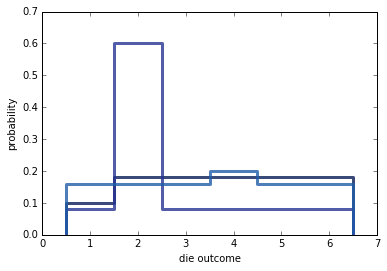

In [37]:
%matplotlib inline
import thinkplot
import matplotlib.pyplot as plt

thinkplot.Pmf(thinkstats2.Pmf({1: .1, 2: (1-.1)/5,
                               2: (1-.1)/5,
                               3: (1-.1)/5,
                               4: (1-.1)/5,
                               5: (1-.1)/5,
                               6:(1-.1)/5}))
thinkplot.Pmf(thinkstats2.Pmf({1: (1-.6)/5,
                               2: .6,
                               3: (1-.6)/5,
                               4: (1-.6)/5,
                               5: (1-.6)/5,
                               6:(1-.6)/5}))
thinkplot.Pmf(thinkstats2.Pmf({1: (1-.2)/5,
                               2: (1-.2)/5,
                               3: (1-.2)/5,
                               4: .2,
                               5: (1-.2)/5,
                               6:(1-.2)/5}))

plt.xlabel('die outcome')
plt.ylabel('probability')
plt.show()

Even with this very simplified model of the alternative hypothesis there are infinitely many possibilities.  In order to see our different tests perform for these alternative hypotheses, we will search over a small discrete number of them.  It's pretty easy to see that the die outcomes are interchangeable, and thus we can assume that die outcome of 1 is the one with differing probability.

In [42]:
# we will vary the probability of the die outcome 1 from 0 to 1 in steps of .1
prob_1 = np.linspace(0, 1, 11)

# To smooth out variability we will repeat each alternate hypothesis 100 times
n_reps = 100
p_vals_abs = np.zeros((len(prob_1), n_reps))
p_vals_chi2 = np.zeros((len(prob_1), n_reps))

for i, p_1 in enumerate(prob_1):
    print i, p_1
    die_probs = {1: p_1}
    for j in range(2, 7):
        die_probs[j] = (1 - p_1)/5.0

    for t in range(n_reps):
        rolls = simulate_die(die_probs, sum(observed.values()))
        trial_abs_stat = abs_deviation_stat(rolls, expected)
        trial_chi2_stat = chi2_stat(rolls, expected)
        p_vals_abs[i, t], p_vals_chi2[i, t] = get_p_vals(trial_abs_stat,
                                                         trial_chi2_stat,
                                                         sum(observed.values()),
                                                         n_trials_for_p_value)

0 0.0
1 0.1
2 0.2
3 0.3
4 0.4
5 0.5
6 0.6
7 0.7
8 0.8
9 0.9
10 1.0


To finish our analysis, let's plot the probability of commiting a type 2 error for each of the tests as a function of the probability of the die outcome of 1.

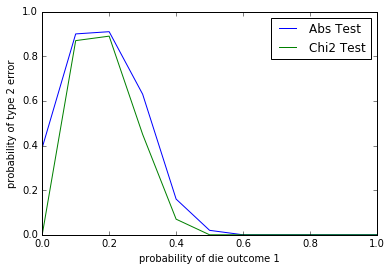

In [46]:
plt.plot(prob_1, [np.mean(p_vals_abs[i, :] > .05) for i in range(len(prob_1))])
plt.plot(prob_1, [np.mean(p_vals_chi2[i, :] > .05) for i in range(len(prob_1))])
plt.legend(['Abs Test', 'Chi2 Test'])
plt.xlabel('probability of die outcome 1')
plt.ylabel('probability of type 2 error')
plt.show()

At least for this model of the alternative hypothesis, the chi2 test seems to be superior.  Next, I'll search over a space of alternate hypotheses by sampling a random set of probabilities for each die outcome.

In [70]:
from scipy.stats import dirichlet

n_random = 10
probs = []
p_vals_abs = np.zeros((n_random, n_reps))
p_vals_chi2 = np.zeros((n_random, n_reps))

for i in range(n_random):
    # sample some random probabilities from a Dirichlet distribution
    # https://en.wikipedia.org/wiki/Dirichlet_distribution
    probs.append(dirichlet.rvs([1]*6))
    for t in range(n_reps):
        die_probs = dict(zip(range(1,7), probs[-1][0]))
        rolls = simulate_die(die_probs, sum(observed.values()))
        trial_abs_stat = abs_deviation_stat(rolls, expected)
        trial_chi2_stat = chi2_stat(rolls, expected)
        p_vals_abs[i, t], p_vals_chi2[i, t] = get_p_vals(trial_abs_stat,
                                                         trial_chi2_stat,
                                                         sum(observed.values()),
                                                         n_trials_for_p_value)

In [71]:
type2_error_abs = [np.mean(p_vals_abs[i, :] > .05) for i in range(n_random)]
type2_error_chi2 = [np.mean(p_vals_chi2[i, :] > .05) for i in range(n_random)]

difference_in_errors = np.asarray(type2_error_abs) - np.asarray(type2_error_chi2)
print difference_in_errors
best_probs = probs[np.argmin(difference_in_errors)][0]
print best_probs

[ 0.01  0.    0.    0.    0.    0.    0.01  0.01  0.    0.  ]
[ 0.22222532  0.16293351  0.09058381  0.34634919  0.00064725  0.17726092]


It looks like we have at least one example where the sum of absolute deviations might be better.  To make sure it's not a fluke, I'm going to up the number of trials to estimate the p-value and for sampling from the alternate hypothesis.

In [72]:
p_vals_abs = np.zeros((1000,))
p_vals_chi2 = np.zeros((1000,))

for t in range(1000):
    if t % 100 == 0:
        print t/1000.0
    die_probs = dict(zip(range(1,7), best_probs))
    rolls = simulate_die(die_probs, sum(observed.values()))
    trial_abs_stat = abs_deviation_stat(rolls, expected)
    trial_chi2_stat = chi2_stat(rolls, expected)
    p_vals_abs[t], p_vals_chi2[t] = get_p_vals(trial_abs_stat,
                                               trial_chi2_stat,
                                               sum(observed.values()),
                                               n_trials_for_p_value)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [73]:
print "type 2 error abs", np.mean(p_vals_abs > .05)
print "type 2 error chi2", np.mean(p_vals_chi2 > .05)

type 2 error abs 0.017
type 2 error chi2 0.0


Determining optimal tests is something that statisticians spend a lot of time thinking about.  The holy grail would be determining what's called the [uniformly most powerful test](https://en.wikipedia.org/wiki/Uniformly_most_powerful_test) (or UMP) for a given situation.  A UMP is a test statistic that yields the lowest probability of a type 2 error for any fixed probability a type 1 error.  It is my understanding that UMPs are relatively rare (i.e. we don't know about too many of them).  I tried to find out whether or not the chi2 test is a UMP for proportion testing and was not able to determine definitively whether or not this is the case.  Unfortunately, this is getting to the outer limits of my stats knowledge, so if you find anything out about this question (or just information regarding UMPs), I'd be excited to hear about it.